In [88]:
%%writefile Test_Tools_Simple.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import Analysis_Funs as af

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import ind.Ind_Model_Base as Ind_Model_Base
from base.Constants import PLOT_TITLE


class FactorTest():
    def __init__(self,start,end,target_field,blenchmark_name='沪深500',freq="d"):
        assert freq !='w' ,"freq 禁止直接写w，自动resample week经常会选在周末而导致计算ic没有交集"

        self.main_field = target_field
        self.sample = blenchmark_name
        self.freq = freq
        self.start = start
        self.end = end
        self.rank_ic = None
        self.res = None
        self.ind_ret_df = None
        self.ind_binned = None
        
    def process_ind_simple(self,ind,ret,need_descript=True):
        # 简单测试，既提前准备好数据，不再由本类准备数据。
        if need_descript:
            self.rank_ic = af.get_rank_ic(ind[self.main_field], ret)
            self.res = pd.DataFrame([af.get_ic_desc(self.rank_ic)], columns=['rankIC','rankIC_std','rankIC_T','rankIC_P'])
            self.res['ICIR']=round(af.get_ic_ir(self.rank_ic),6)
            self.res['winning']=round(af.get_winning_rate(self.rank_ic),6)
        
        common_index = ind.index.get_level_values(0).unique().intersection(ret.index.get_level_values(0).unique())
        ind_resample = ind[[self.main_field]]
        ind_resample = ind_resample.loc[common_index]
        self.ind_ret_df = pd.concat([ind_resample, ret], axis=1)
        self.ind_ret_df.dropna(axis=0,inplace=True)
        # 分箱
        self.ind_binned = self.ind_ret_df.groupby(level=0, group_keys=False).apply(lambda x: pretreat.binning(x, deal_column=self.main_field,box_count=10, inplace=True))

    def plot(self,only_binned=False):
        if only_binned:
            self.binned_plot(only_binned)
        else:
            # self.rankIC_plot()
            self.binned_plot()

    def rankIC_plot(self):
        fig = plt.figure(figsize=(1420/72/2,420/72))
        ax = fig.gca()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
        ax.yaxis.grid()
        # 高密度时 width 必须大于1，否则会显示不出来
        width_ = 0.5
        if len(self.rank_ic) > 500:
            width_ = 1
        plt.bar([pd.to_datetime(x).strftime('%Y%m%d') for x in self.rank_ic.index.values],self.rank_ic.fillna(0),width=width_)
        plt.title('rankIC', **PLOT_TITLE)
        plt.show()

        fig = plt.figure(figsize=(1420/72,420/72/7))
        ax = fig.gca()
        ax.xaxis.set_visible(False) 
        ax.yaxis.set_visible(False)
        ax.table(cellText=self.res.values.round(6),colLabels=self.res.columns,cellLoc='center', bbox = [0.0, 0.0, 1, 1]) 
        plt.title('desc', **PLOT_TITLE)
        plt.show()
        
        
    def get_ind_binned_ret_avg(self):
        # 此功能与 binned_plot 中，重复。
        no_need = self.ind_binned.columns.difference(['group_label','ret_forward'],sort=False).to_list()
        ind_binned_noindex = self.ind_binned.reset_index().drop(no_need+['code'],axis=1)
        return ind_binned_noindex.drop(['date'],axis=1).dropna().set_index('group_label').groupby(level=0).apply(lambda x: x['ret_forward'].sum())
    
    def get_ind_binned_ret_cumsum(self):
        # 此功能与 binned_plot 中，重复。
        no_need = self.ind_binned.columns.difference(['group_label','ret_forward'],sort=False).to_list()
        ind_binned_noindex = self.ind_binned.reset_index().drop(no_need+['code'],axis=1)
        ind_binned_ret_date = ind_binned_noindex.set_index(['date', 'group_label']).groupby(level=0).apply(lambda x: x.groupby(level=1).agg(sum))
        return ind_binned_ret_date.groupby(level=1).agg('cumsum')
    
        
    def binned_plot(self, only_binned=False):
        # 去除绘图不需要的原始因子和code
        no_need = self.ind_binned.columns.difference(['group_label','ret_forward'],sort=False).to_list()
        ind_binned_noindex = self.ind_binned.reset_index().drop(no_need+['code'],axis=1)
        # 按日期分组，组内再按分箱分组求总收益,结果会被倒序。
        ind_binned_ret_date = ind_binned_noindex.set_index(['date', 'group_label']).groupby(level=0).apply(lambda x: x.groupby(level=1).agg(sum))
        fig = plt.figure(figsize=(1420/72,320/72))
        ind_binned_ret_all = ind_binned_noindex.drop(['date'],axis=1).dropna().set_index('group_label').groupby(level=0).apply(lambda x: x['ret_forward'].sum())
        plt.bar(ind_binned_ret_all.index,ind_binned_ret_all)
        plt.title('分箱平均收益', **PLOT_TITLE)
        plt.show()
        
        if only_binned:
            return

        blenchmark = smpl.get_benchmark(name=self.sample, start=self.start, end=self.end)
        blenchmark_re = smpl.resample_stockdata_low(blenchmark.data,freq=self.freq)
        blenchmark_ret = smpl.get_forward_return(blenchmark_re,'close')
        blenchmark_ret.reset_index('code',drop=True,inplace=True)
        blenchmark_cum = blenchmark_ret.cumsum()

        fig = plt.figure(figsize=(1420/72,320/72))
        lns = ind_binned_ret_date.groupby(level=1).apply(lambda x: plt.plot(x.index.get_level_values(0).unique().tolist(),x.values.tolist(),label=x.index.get_level_values(1)[0]))
        ax2 = plt.gca().twinx()
        lns = [x[0] for x in lns.values] # lns,为了合并legend
        lns += ax2.plot(blenchmark_ret,linestyle=":", linewidth=2,color="black",label='bm')
        labs = [l.get_label() for l in lns]
        legend = plt.legend(lns, labs,loc='upper left',fontsize='x-small',title='反序\n注意\n10最小')
        legend.get_title().set_fontsize(fontsize = 12)
        plt.grid(linestyle="dotted",color="lightgray")
        plt.title('分箱收益变化', **PLOT_TITLE)
        plt.show()

        ind_binned_ret_cum = ind_binned_ret_date.groupby(level=1).apply(lambda x: x.cumsum())
        fig = plt.figure(figsize=(1420/72,320/72))
        lns = ind_binned_ret_cum.groupby(level=1).apply(lambda x: plt.plot(x.index.get_level_values(0).unique().tolist(),x.values.tolist(),label=x.index.get_level_values(1)[0]))
        ax3 = plt.gca().twinx()
        lns = [x[0] for x in lns.values] # lns,为了合并legend
        lns += ax3.plot(blenchmark_cum,linestyle=":", linewidth=2,color="black",label='bm')
        labs = [l.get_label() for l in lns]
        legend = plt.legend(lns, labs,loc='upper left',fontsize='x-small',title='反序\n注意\n10最小')
        legend.get_title().set_fontsize(fontsize = 12)
        plt.grid(linestyle="dotted",color="lightgray")
        plt.title('累计收益率', **PLOT_TITLE)
        plt.show()

Overwriting Test_Tools_Simple.py


In [75]:
# from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

# data = load_cache('base10_train',cache_type=CACHE_TYPE.FACTOR)
# data.dropna(subset=['resvol'], inplace=True)
# data

data_ = data.loc['2020-01-03':'2020-12-30']

codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()
data_replenish = load_cache_adv('all_train_qfq',
                                dates.min().strftime('%Y-%m-%d'),
                                dates.max().strftime('%Y-%m-%d'),
                                cache_type=CACHE_TYPE.STOCK).sort_index()

ret = smpl.get_forward_return(data_replenish,'close')
# ret.name = 'ret_forward'
ret[np.abs(ret)>0.15]=np.nan

# start,end,target_field,blenchmark_name='沪深500',freq="d")

--------------------beta------------------------------------


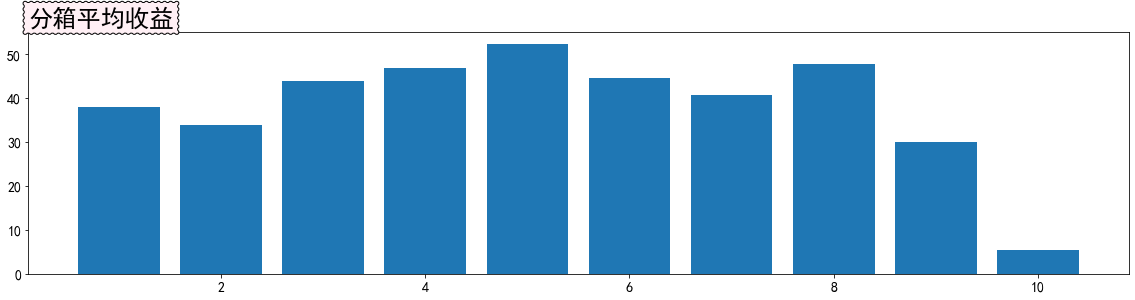

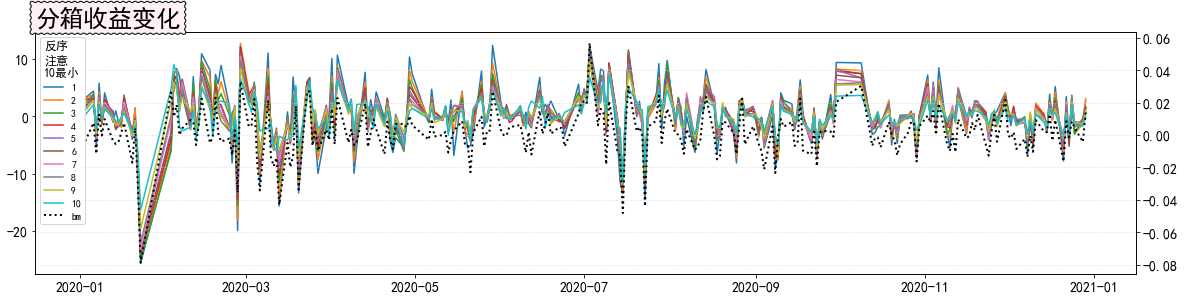

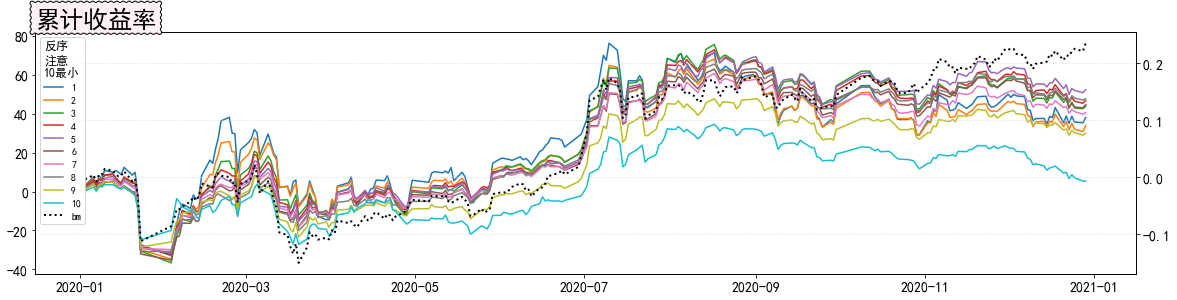

--------------------alpha------------------------------------


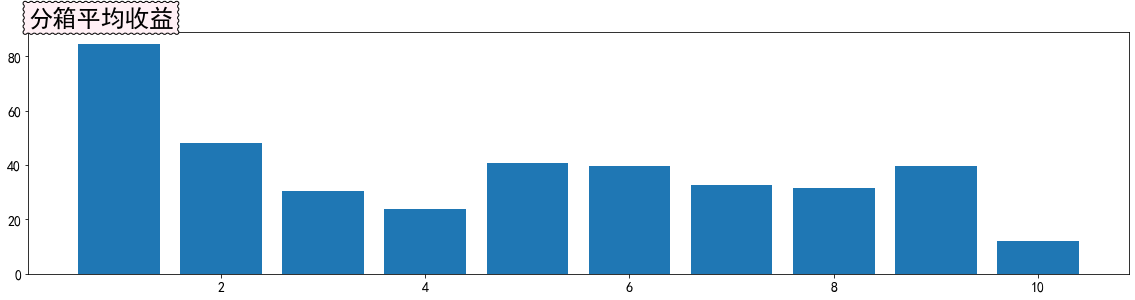

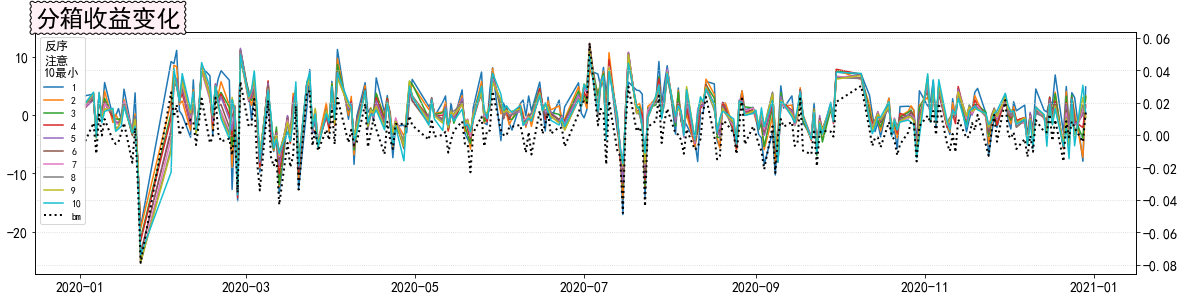

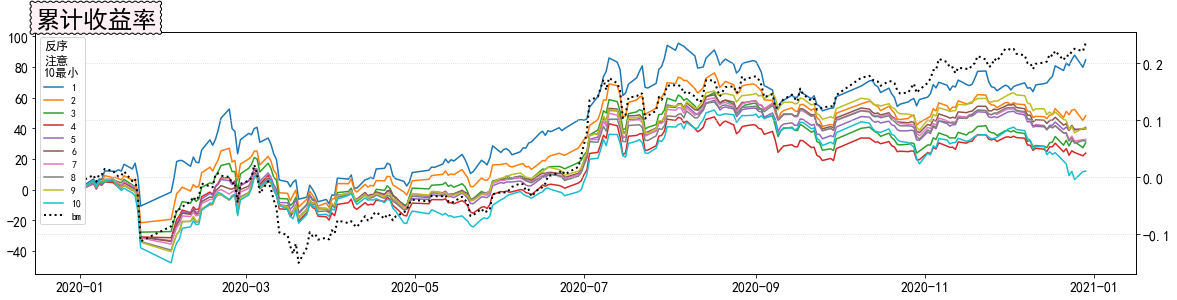

--------------------residual------------------------------------


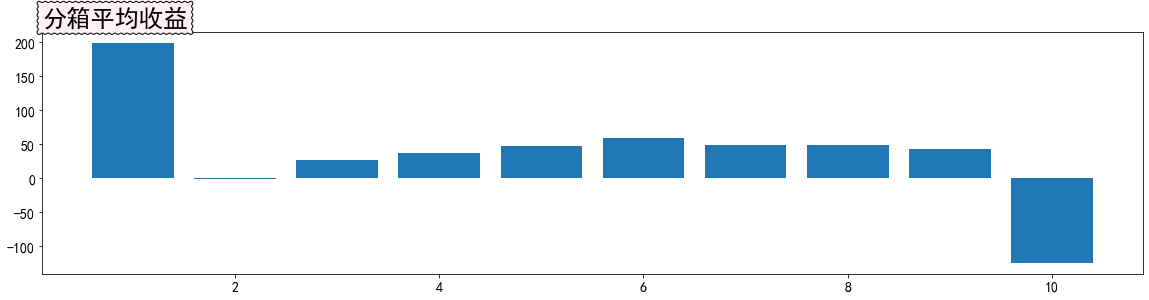

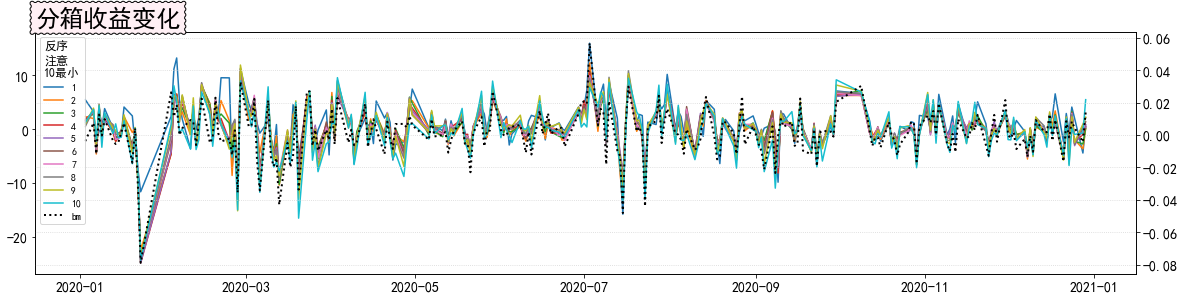

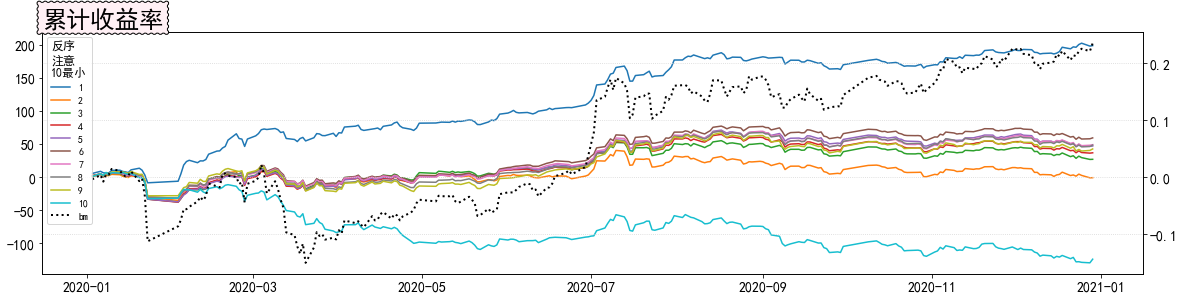

--------------------momentum------------------------------------


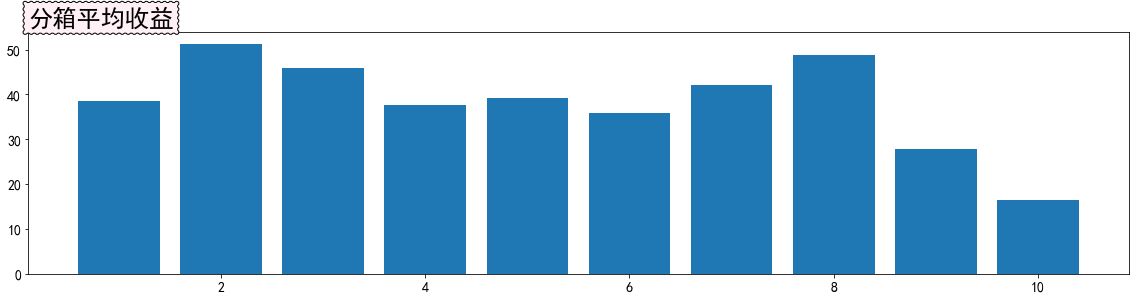

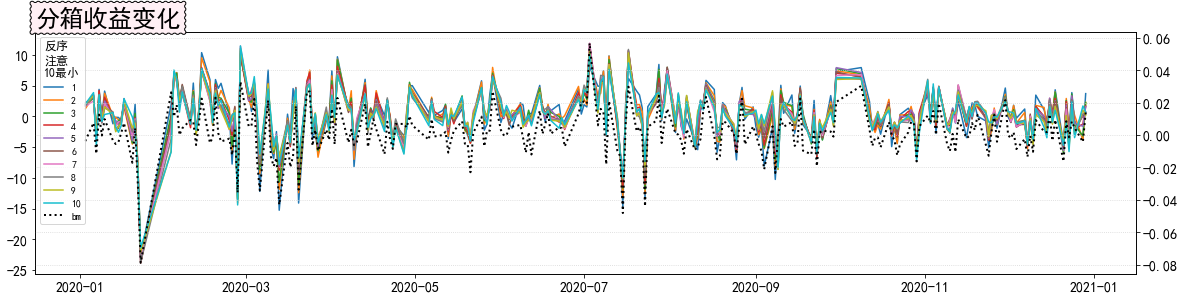

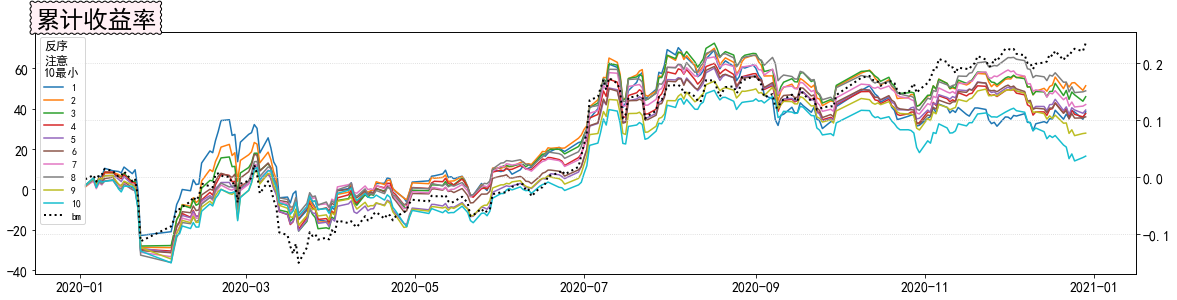

--------------------sizelg------------------------------------


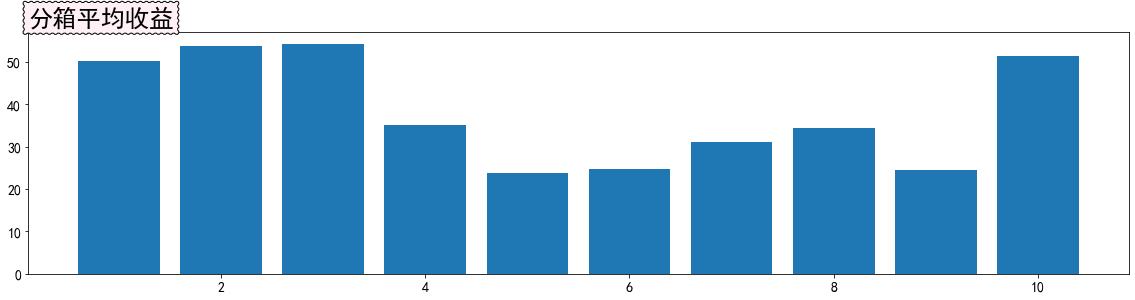

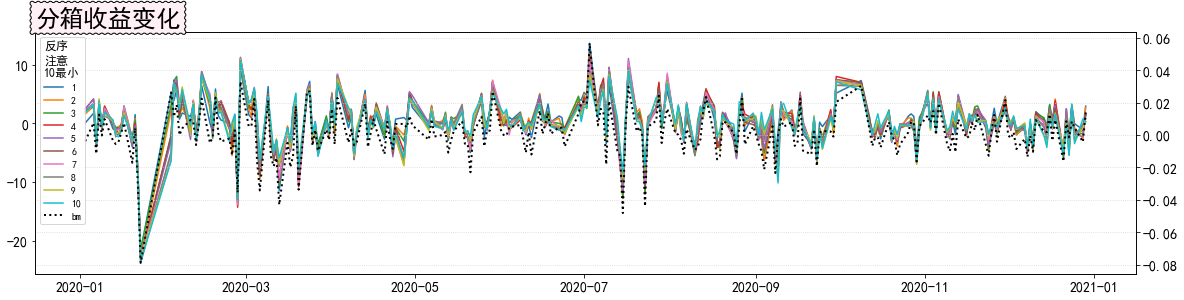

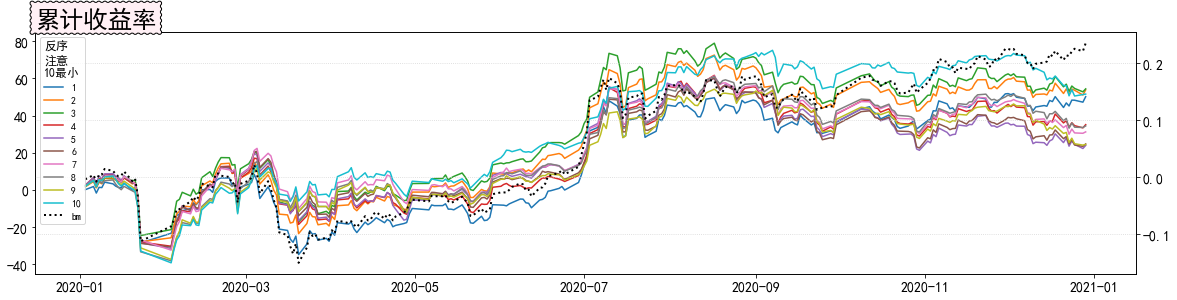

--------------------bp------------------------------------


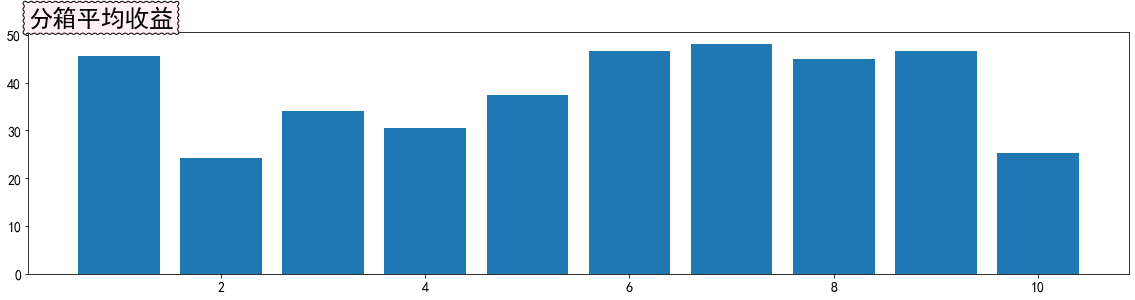

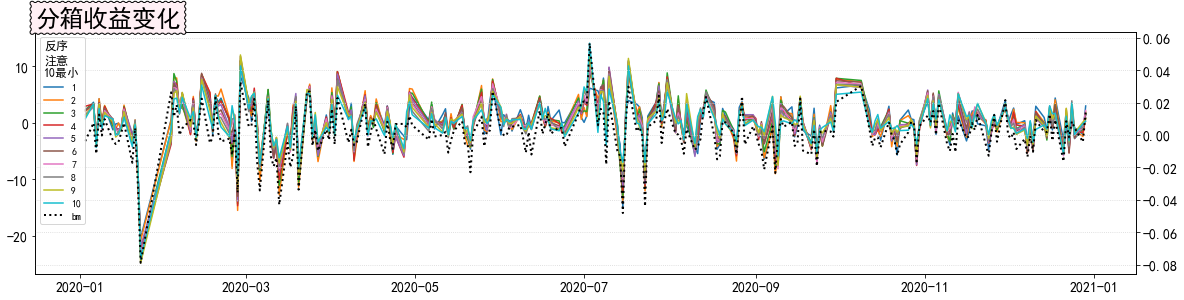

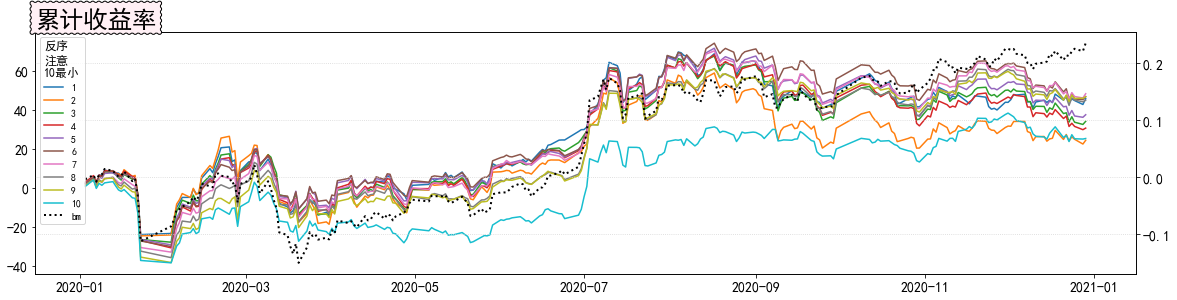

--------------------earnings_yield------------------------------------


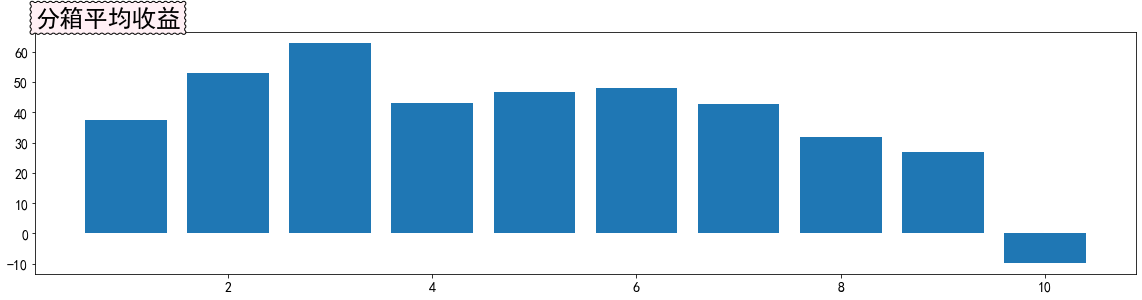

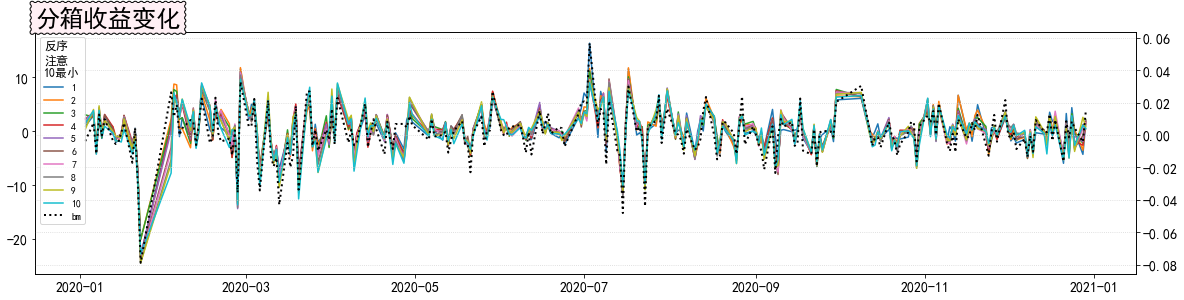

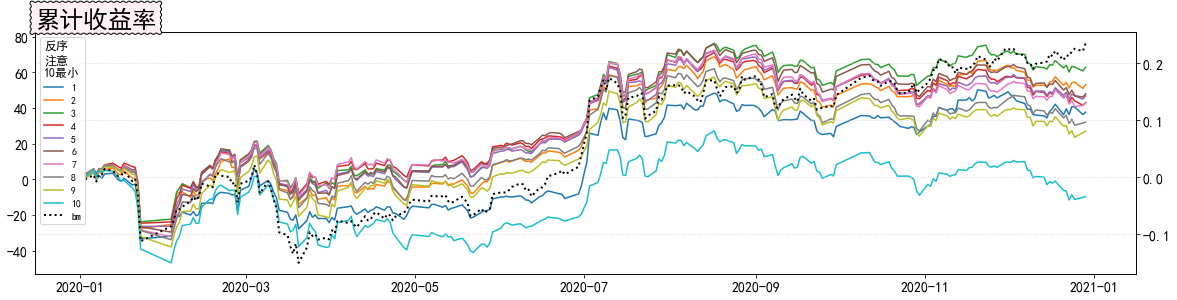

--------------------liquidity------------------------------------


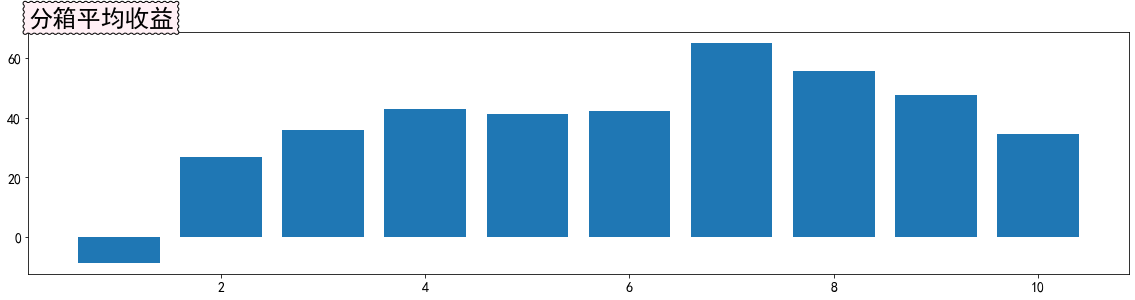

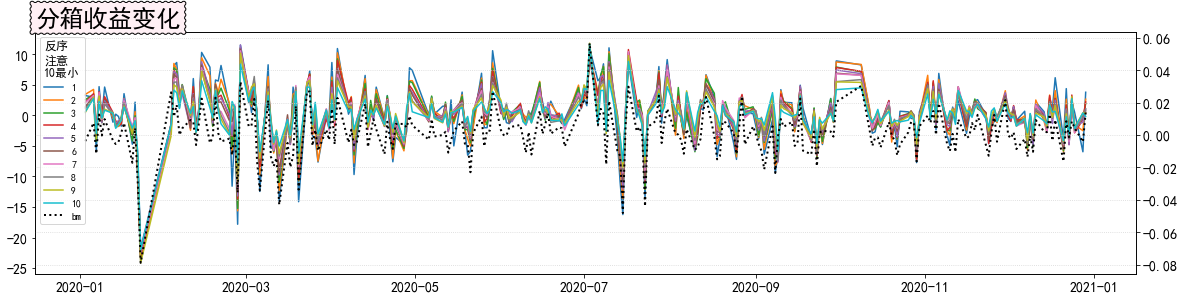

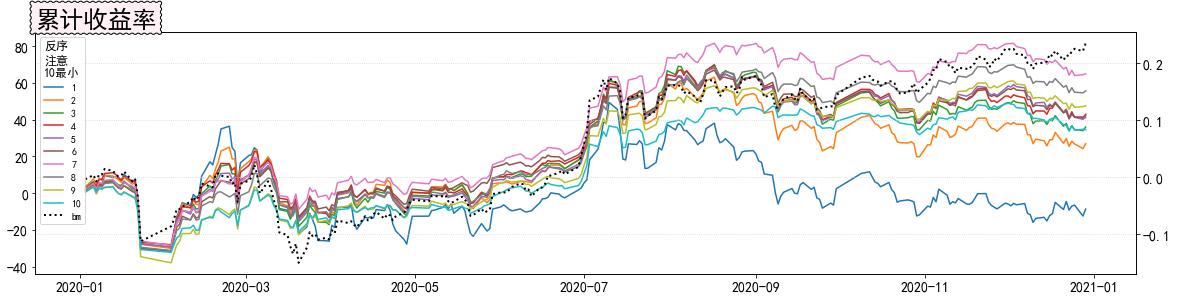

--------------------resvol------------------------------------


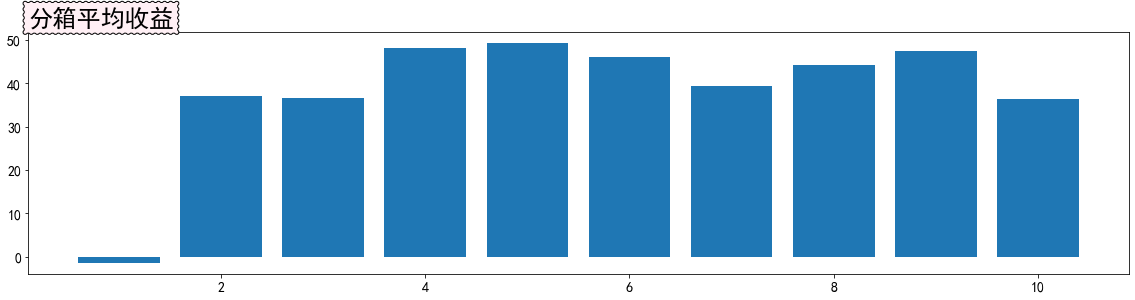

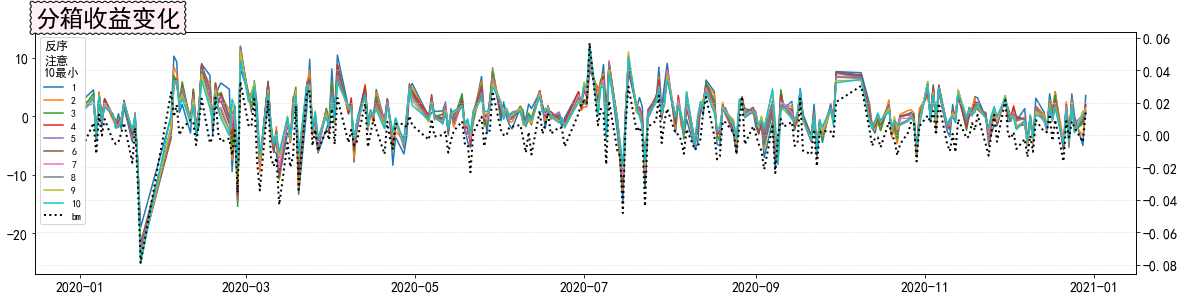

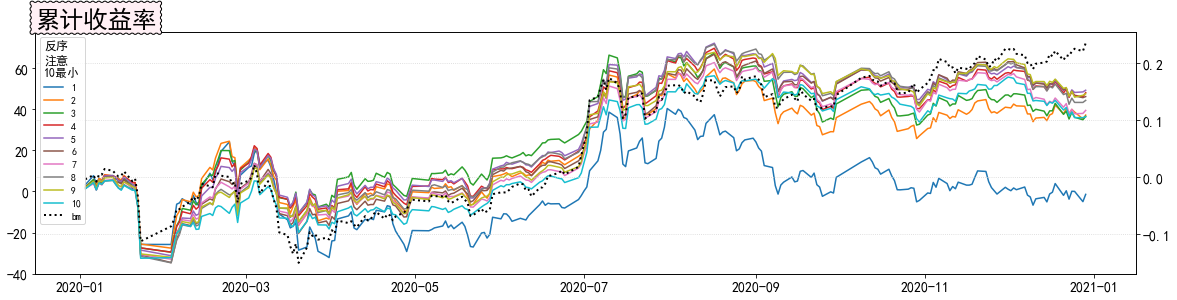

--------------------sizenl------------------------------------


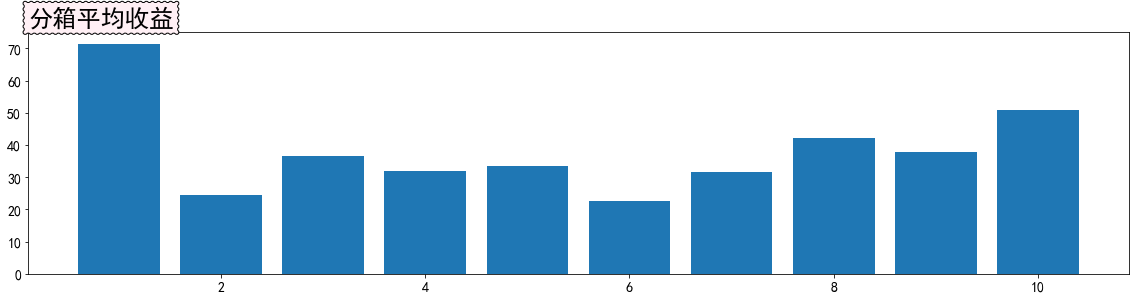

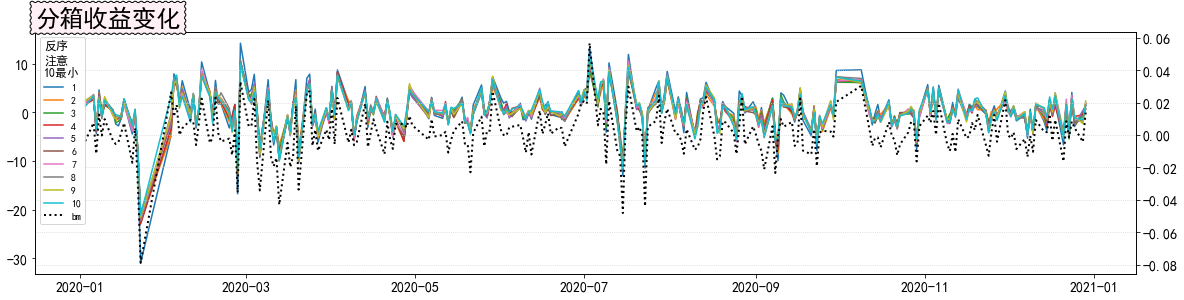

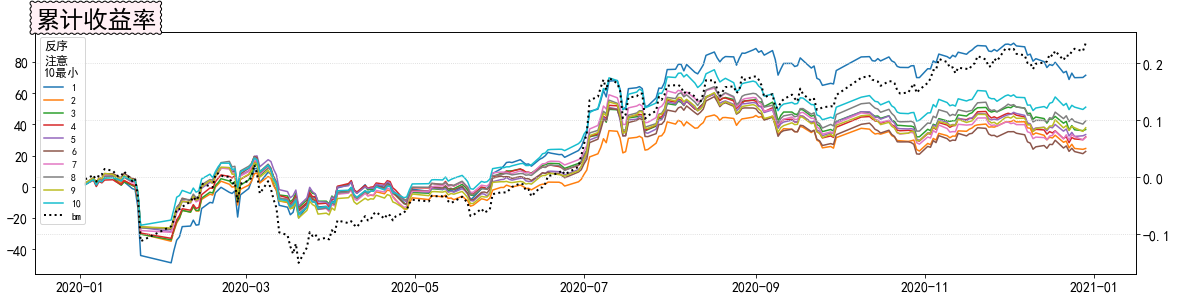

Wall time: 3min 2s


In [83]:
%%time
# from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple
# ,start,end,target_field,blenchmark_name='沪深500',freq="d")

for col in data.columns:
    print('--------------------'+col+'------------------------------------')
    test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field=col,blenchmark_name='沪深300', freq="d")
    test.process_ind_simple(data,ret,need_descript=True)
    test.plot()